# Inference Pipeline with Scikit-learn and Linear Learner

1. fit/train a sklearn pre-processor
   
   it will perform preprocessing of numeric cat cols
   
** numeric : imputation, scaling

** categoric : imputation, one-hot-encoding
   
** also perform batch transformation of train/test data to be used for ml_model training
   
   
2. train sklearn ml model (RF regressor)

3. build up inference-ml-pipeline
    raw_data --> [preprocessing ==> ml_model] --> prediction
    
4. deploy inference-ml-pipeline as an endpoint

5. prediction using the endpoint

In [1]:
!pwd

/home/ec2-user/SageMaker/aws-ml/pipeline/sklearn-pipeline-classification


In [2]:
import sagemaker
from sagemaker import get_execution_role

import numpy as np
import pandas as pd

sagemaker_session = sagemaker.Session()

# Get a SageMaker-compatible role used by this Notebook Instance.
role = get_execution_role()

# S3 prefix
S3_BUCKET = "sklearn-pipeline"
S3_PREFIX = 'sklearn-pipeline-linearRegression'

S3_BUCKET, S3_PREFIX

('sklearn-pipeline', 'sklearn-pipeline-linearRegression')

# 1. Get raw data

In [3]:
#!wget --directory-prefix=./abalone_data_dir https://s3-us-west-2.amazonaws.com/sparkml-mleap/data/abalone/abalone.csv

In [17]:
RAW_FILE       = 'abalone.csv'
WORK_DIRECTORY = 'abalone_data_dir/'

RAW_FILE_PATH  = "{}/{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_TRAIN_PATH = "{}/train_{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_TEST_PATH  = "{}/test_{}".format(WORK_DIRECTORY, RAW_FILE)
RAW_VAL_PATH   = "{}/val_{}".format(WORK_DIRECTORY, RAW_FILE)

X = pd.read_csv(filepath_or_buffer=RAW_FILE_PATH, header=None)
X[8] = np.where(X[8]>8, 0, 1)

train_data = X.head(int(len(X)*0.8)).copy()
test_data  = X.tail(int(len(X)*0.2)).copy()
val_data   = X.tail(int(len(X)*0.2)).drop(columns=[8]).copy()

train_data.to_csv(path_or_buf=RAW_TRAIN_PATH, index=False)
test_data.to_csv(path_or_buf=RAW_TEST_PATH, index=False)
val_data.to_csv(path_or_buf=RAW_VAL_PATH, index=False)

print(train_data.shape, test_data.shape, val_data.shape)
print(len(train_data)+len(test_data))

print(X.shape)
X.head(2)

(3341, 9) (835, 9) (835, 8)
4176
(4177, 9)


,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.15,0
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.07,1


In [19]:
train_data[8].value_counts(), test_data[8].value_counts()

(0    2233
 1    1108
 Name: 8, dtype: int64,
 0    536
 1    299
 Name: 8, dtype: int64)

## Upload the data for training

In [20]:
s3_input_raw_train = sagemaker_session.upload_data(
    path=RAW_TRAIN_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_train'))

s3_input_raw_test = sagemaker_session.upload_data(
    path=RAW_TEST_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_test'))

s3_input_raw_val = sagemaker_session.upload_data(
    path=RAW_VAL_PATH, 
    bucket=S3_BUCKET,
    key_prefix='{}/{}'.format(S3_PREFIX, 'data_val'))

s3_input_raw_train, s3_input_raw_test, s3_input_raw_val

('s3://sklearn-pipeline/sklearn-pipeline-linearRegression/data_train/train_abalone.csv',
 's3://sklearn-pipeline/sklearn-pipeline-linearRegression/data_test/test_abalone.csv',
 's3://sklearn-pipeline/sklearn-pipeline-linearRegression/data_val/val_abalone.csv')

# Data pre-processing

## setup

In [7]:
PP_SCRIPT_NAME = 'sklearn_abalone_featurizer.py'

# preprocessor setup
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"
sklearn_preprocessor = SKLearn(
                            entry_point=PP_SCRIPT_NAME,
                            role=role,
                            framework_version=FRAMEWORK_VERSION,
                            train_instance_type="ml.c4.xlarge",
                            sagemaker_session=sagemaker_session
                            )

## train

In [8]:
sklearn_preprocessor.fit({'train': s3_input_raw_train})

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


2020-09-17 07:48:43 Starting - Starting the training job...
2020-09-17 07:48:45 Starting - Launching requested ML instances......
2020-09-17 07:50:04 Starting - Preparing the instances for training......
2020-09-17 07:51:14 Downloading - Downloading input data......
2020-09-17 07:51:46 Training - Downloading the training image..2020-09-17 07:52:23,497 sagemaker-training-toolkit INFO     Imported framework sagemaker_sklearn_container.training
2020-09-17 07:52:23,499 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-17 07:52:23,509 sagemaker_sklearn_container.training INFO     Invoking user training script.
2020-09-17 07:52:23,878 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-17 07:52:23,889 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-17 07:52:23,900 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2020-09-17 07:52:23,913 s

### batch transform the raw data to train/test data
required for training the ML model

In [9]:
"""
raw data + label : 9
features + label : 12

raw data : 8
features : 11 (this is pred model required data)

"""
print()

In [10]:
# Define a SKLearn Transformer from the trained SKLearn Estimator
pp_transformer = sklearn_preprocessor.transformer(
                                                    instance_count=1, 
                                                    instance_type='ml.m5.xlarge',
                                                    assemble_with = 'Line',
                                                    accept = 'text/csv'
                                                 )

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [11]:
# Preprocess training data : s3_input_raw_train
pp_transformer.transform(s3_input_raw_train, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_train = pp_transformer.output_path

Waiting for transform job: sagemaker-scikit-learn-2020-09-17-07-52-56-695
..............................
2020-09-17T07:57:51.651:[sagemaker logs]: MaxConcurrentTransforms=1, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
2020-09-17 07:57:48,354 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-17 07:57:48,357 INFO - sagemaker-containers - No GPUs detected (normal if no gpus installed)
2020-09-17 07:57:48,357 INFO - sagemaker-containers - nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;

worker_rlimit_nofile 4096;

events {
  worker_connections 2048;
}

http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;

  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }

  server {
    listen 8080 deferred;
    client_max_body_size 0;

    keepalive_timeout 3;

    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forward

In [ ]:
# batch preprocess test data : s3_input_raw_test
pp_transformer.transform(s3_input_raw_test, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_test = pp_transformer.output_path

Waiting for transform job: sagemaker-scikit-learn-2020-09-17-09-22-40-476
....

In [ ]:
# only useful to assessing the ml_model only endpoint
"""
# batch preprocess val data : s3_input_raw_val
pp_transformer.transform(s3_input_raw_val, content_type="text/csv")
print("Waiting for transform job: " + pp_transformer.latest_transform_job.job_name)
pp_transformer.wait()
s3_pp_val = pp_transformer.output_path
"""
s3_pp_val = None

In [ ]:
s3_input_raw_train

In [ ]:
s3_pp_train, s3_pp_test, s3_pp_val

# ML model (sklearn)

In [54]:
y_true = [0, 1, 1, 0, 0]

y_pred = [0, 1, 0, 1, 1]
y_score = [0.4, 0.8, 0.1, 0.9, 0.9]

target_names = ['small', 'large']

In [55]:
accuracy, precision, recall, cr = classification_metrices(y_true=y_true, y_pred=y_pred, 
                                                          target_names=target_names, verbose=True)

accuracy  : 0.4
precision : 0.42
recall    : 0.42

Classification report : 
              precision    recall  f1-score   support

       small       0.50      0.33      0.40         3
       large       0.33      0.50      0.40         2

    accuracy                           0.40         5
   macro avg       0.42      0.42      0.40         5
weighted avg       0.43      0.40      0.40         5



In [59]:
from sklearn.metrics import plot_precision_recall_curve

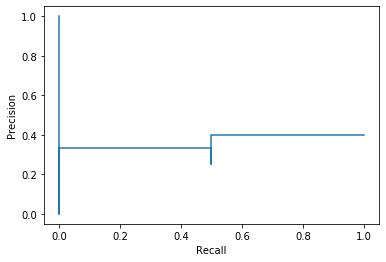

In [61]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

prec, recall, _ = precision_recall_curve(y_true, y_score,
                                         pos_label=None)
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

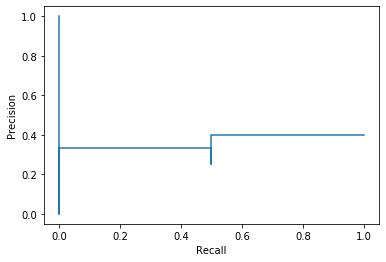

In [67]:
p = pr_display.figure_
p

In [71]:
import matplotlib.pyplot as plt

In [76]:
ax = pr_display.ax_
ax

In [78]:
plt.figure( figsize=(6, 5) )
#sns.set_style("whitegrid")



<Figure size 432x360 with 0 Axes>

<Figure size 432x360 with 0 Axes>

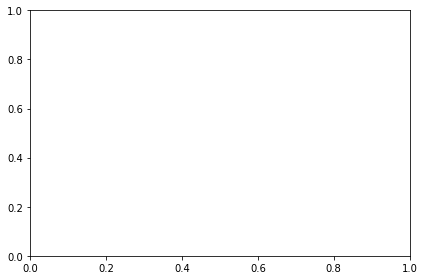

In [80]:
fig, ax = plt.subplots()

ax = pr_display.ax_

ax.set_xlim([0, 1])
ax.set_ylim([0, 1.1])
ax.set_ylabel('xTrue Positive Rate')
ax.set_xlabel('xFalse Positive Rate')

plt.tight_layout()
plt.savefig( "plot.png" )
plt.show()

In [88]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score



NameError: name 'os' is not defined

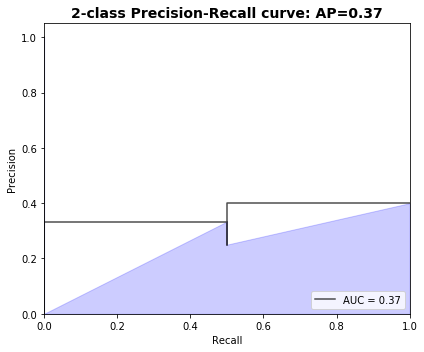

In [89]:
plot_precisionRecall_curve( y_score=y_score, y_true=y_true, path_saveplot="", show_plot=True )

In [106]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [111]:
def plot_cm(y_pred=None, y_true=None, path_saveplot=None, show_plot=True, plot_size=(8,6) ):
    cf_matrix = confusion_matrix(y_true, y_pred)

    ac = accuracy_score( y_true, y_pred )
    all_vals = precision_recall_fscore_support(y_true, y_pred )
    precision = all_vals[0][1]
    recall = all_vals[1][1]
    fscore = all_vals[2][1]
    support = all_vals[3][1]

    text_print_plot = \
    """
    Confusion Matrix
    {} = {} 
    {} = {}, {} = {}
    {} = {}
    {} = {}
    """.format(
        'Accuracy', round(ac,2), 
        'Precision', round(precision,2), 
        'Recall', round(recall, 2),
        'Fscore', round(fscore, 2),
        'Support', support
    )
    
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.1%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n\n{v2}\n\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.figure( figsize=plot_size )
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    
    plt.title(text_print_plot, fontweight='bold', fontsize=14)
    plt.xlabel('pred', fontsize=14)
    plt.ylabel('true', fontsize=14)
    plt.tight_layout()
    
    path = os.path.join(path_saveplot, "model_pr_curve_plot.png")
    plt.savefig( path )
    if( show_plot ):
        plt.show()
    
    plt.close()

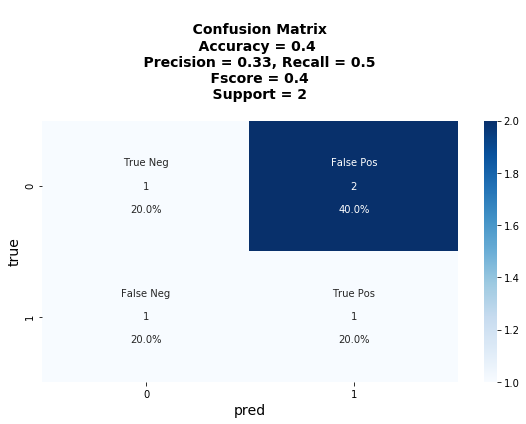

In [112]:
import os
plot_cm(y_pred=y_pred, y_true=y_true, path_saveplot='abalone_data_dir/artifacts', show_plot=True )

## setup

In [ ]:
ML_MODEL_SCRIPT_NAME = "model_script.py"

from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = '0.23-1'
ml_estimator = SKLearn(
                    entry_point=ML_MODEL_SCRIPT_NAME,
                    role = get_execution_role(),
                    train_instance_count=1,
                    train_instance_type='ml.c5.xlarge',
                    framework_version=FRAMEWORK_VERSION,
                    base_job_name='rf-scikit',
                    metric_definitions=[
                                        {'Name': 'median-AE',
                                         'Regex': "AE-at-50th-percentile: ([0-9.]+).*$"}
                                        ],
                    hyperparameters = {'n-estimators': 100,
                                       'min-samples-leaf': 2,
                                       'features': 'CRIM ZN INDUS CHAS NOX RM AGE DIS RAD TAX PTRATIO B LSTAT',
                                       'target': 'target'
                                      }
                    )

## train

In [ ]:
# TRAIN the model
ml_estimator.fit({'train':s3_pp_train, 'test': s3_pp_test}, wait=True)

# Serial Inference Pipeline

In [ ]:
from sagemaker.model import Model
from sagemaker.pipeline import PipelineModel
import boto3
from time import gmtime, strftime

timestamp_prefix = strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# step_1 : get models
pp_transformer_model = sklearn_preprocessor.create_model()
ml_estimator_model   = ml_estimator.create_model()

# step_2 : set-up pipeline
model_name    = 'sklearn-inference-pipeline-' + timestamp_prefix
endpoint_name = 'sklearn-inference-pipeline-ep-' + timestamp_prefix
ml_pipeline_model = PipelineModel(
                                    name=model_name, 
                                    role=role, 
                                    models=[
                                            pp_transformer_model, 
                                            ml_estimator_model
                                            ]
                                    )

In [ ]:
# batch prediction job

"""
ml_pipeline_tf = ml_pipeline_model.transformer(
                                            instance_count=1, 
                                            instance_type='ml.m5.xlarge',
                                            assemble_with = 'Line',
                                            accept = 'text/csv')

# input : s3_input_raw_val (raw input data)
ml_pipeline_tf.transform(s3_input_raw_val, content_type="text/csv")
print("Waiting for transform job: " + ml_pipeline_tf.latest_transform_job.job_name)
ml_pipeline_tf.wait()
s3_pred_val = ml_pipeline_tf.output_path
s3_pred_val
"""
print()

## deploy pipeline model

In [ ]:
#sm_model.deploy(initial_instance_count=1, instance_type='ml.c4.xlarge', endpoint_name=endpoint_name)
ml_pipeline_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge', endpoint_name=endpoint_name)

# predict from pipeline endpoint

In [ ]:
endpoint_name

In [ ]:
test_data.head(1).values

In [ ]:
from sagemaker.predictor import json_serializer, csv_serializer, json_deserializer, RealTimePredictor
from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON


payload = 'M, 0.43, 0.33, 0.095, 0.34, 0.1315, 0.085, 0.11' # 14
# b'[7.8421190476190485]'
# b'[8.006166666666667]'

predictor = RealTimePredictor(
    endpoint=endpoint_name,
    sagemaker_session=sagemaker_session,
    serializer=csv_serializer,
    content_type=CONTENT_TYPE_CSV,
    accept=CONTENT_TYPE_JSON)

print(predictor.predict(payload))

In [ ]:
stop here

## predict : only using model

#### deploy model

In [ ]:
# deploy only the - ml model
ml_predictor = ml_estimator.deploy(instance_type='ml.m4.xlarge', initial_instance_count=1)

#### get test data

In [ ]:
import json
import io
from urllib.parse import urlparse
import boto3

def get_csv_output_from_s3(s3uri, file_name):
    parsed_url = urlparse(s3uri)
    bucket_name = parsed_url.netloc
    prefix = parsed_url.path[1:]
    s3 = boto3.resource('s3')
    print(bucket_name)
    print(prefix)
    print(file_name)
    obj = s3.Object(bucket_name, '{}/{}'.format(prefix, file_name))
    return obj.get()["Body"].read().decode('utf-8')   

In [ ]:
import pandas as pd

path       = preprocessed_val
batch_file = 'abalone_val.csv' # imp
output = get_csv_output_from_s3(path, '{}.out'.format(batch_file))
validate_df = pd.read_csv(io.StringIO(output), sep=",", header=None)
print(validate_df.shape)
validate_df.sample(2) 

#### prediction

In [ ]:
# `data` is a NumPy array or a Python list.
# `response` is a NumPy array.

#payload = validate_df.drop(columns=[0]).values
payload = validate_df.values

response = ml_predictor.predict(payload)
response

In [ ]:
stop

## Delete Endpoint <a class="anchor" id="delete_endpoint"></a>
Once we are finished with the endpoint, we clean up the resources!

In [ ]:
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)

In [ ]:
sm_client = sagemaker_session.boto_session.client('sagemaker')
sm_client.delete_endpoint(EndpointName=endpoint_name)